In [1]:
import json
import sys
sys.path.append('/Users/wastechs/Documents/git-repos/energy-efficiency')
from validation.gp.create_train_inference import create_train_inference_gp
from lib.util import helper, data_preprocessing
import torch
import gpytorch

### 30 minutes agg.

In [2]:
X_train, y_train, X_test, y_test, n_train = data_preprocessing.gp_preprocess(
    machine='hauptluftung_30T', 
    freq=10,
    normalize_time=True
    )

In [3]:
## Locally Periodic Kernel ##
period_constraint_short = gpytorch.constraints.Interval(0.06, 0.10) ## short term

seasonal_periodic_short = gpytorch.kernels.ScaleKernel(
    gpytorch.kernels.PeriodicKernel(
        period_length_constraint=period_constraint_short
        )
    )

seasonal_rbf_short = gpytorch.kernels.ScaleKernel(
    gpytorch.kernels.RBFKernel()
)

locally_short_periodic = seasonal_periodic_short * seasonal_rbf_short

period_constraint_long = gpytorch.constraints.Interval(0.18, 0.21) ## long term

seasonal_periodic_long = gpytorch.kernels.ScaleKernel(
    gpytorch.kernels.PeriodicKernel(
        period_length_constraint=period_constraint_long
        )
    )

seasonal_rbf_long = gpytorch.kernels.ScaleKernel(
    gpytorch.kernels.RBFKernel()
)

locally_long_periodic = seasonal_periodic_long * seasonal_rbf_long

## Local Variations ##
local_variation_alpha = gpytorch.priors.GammaPrior(1, 0.5)

local_variation = gpytorch.kernels.ScaleKernel(
    gpytorch.kernels.RQKernel()
    )
    
local_variation.alpha = local_variation_alpha


#covar_module = locally_long_periodic + local_variation ## the best

covar_module1 = locally_short_periodic + locally_long_periodic + local_variation 
covar_module2 = locally_short_periodic
covar_module3 = locally_short_periodic + local_variation 
covar_module4 = locally_short_periodic + locally_long_periodic

covar_module5 = locally_long_periodic
covar_module6 = locally_long_periodic + local_variation 

covar_module7 = local_variation

covar_combinations = [
    covar_module1, covar_module2, covar_module3, 
    covar_module4, covar_module5, covar_module6, 
    covar_module7]

### Create, Train, and Perform Inference

In [ ]:
for kernel in covar_combinations:

    X_train, y_train, X_test, y_test, n_train = data_preprocessing.gp_preprocess(
    machine='hauptluftung_30T', 
    freq=30,
    normalize_time=True
    )

    func_preds_mean_inv, func_preds_var_inv, observed_preds, mse, mape = create_train_inference_gp(
        kernel_gen=kernel,
        train_x=X_train,
        train_y=y_train,
        test_x=X_test,
        test_y=y_test,
        n_train=n_train,
        training_iter=100,
        lr=0.1,
        time_agg='30T',
        machine='Hauptluftung',
        update_score=False
    )

Iter 1 , Loss = 0.9487914740213804 , Noise = 0.6932471990585327
Iter 2 , Loss = 0.91600067410229 , Noise = 0.6444966793060303
Iter 3 , Loss = 0.8838438732381294 , Noise = 0.5982298254966736
Iter 4 , Loss = 0.8524070755654306 , Noise = 0.5544294118881226
Iter 5 , Loss = 0.8217666955118453 , Noise = 0.5130710005760193
Iter 6 , Loss = 0.7920075535227765 , Noise = 0.4741227924823761
Iter 7 , Loss = 0.7632588534640888 , Noise = 0.4375460147857666
Iter 8 , Loss = 0.7357038436819586 , Noise = 0.4032948911190033
Iter 9 , Loss = 0.709517447151507 , Noise = 0.37131738662719727
Iter 10 , Loss = 0.6847540378169467 , Noise = 0.34155601263046265
Iter 11 , Loss = 0.6613767981590728 , Noise = 0.3139481246471405
Iter 12 , Loss = 0.6393476558649982 , Noise = 0.28842633962631226
Iter 13 , Loss = 0.6186708635003783 , Noise = 0.26491889357566833
Iter 14 , Loss = 0.5994300695466683 , Noise = 0.24335040152072906
Iter 15 , Loss = 0.581794189986682 , Noise = 0.22364301979541779
Iter 16 , Loss = 0.5659984066656

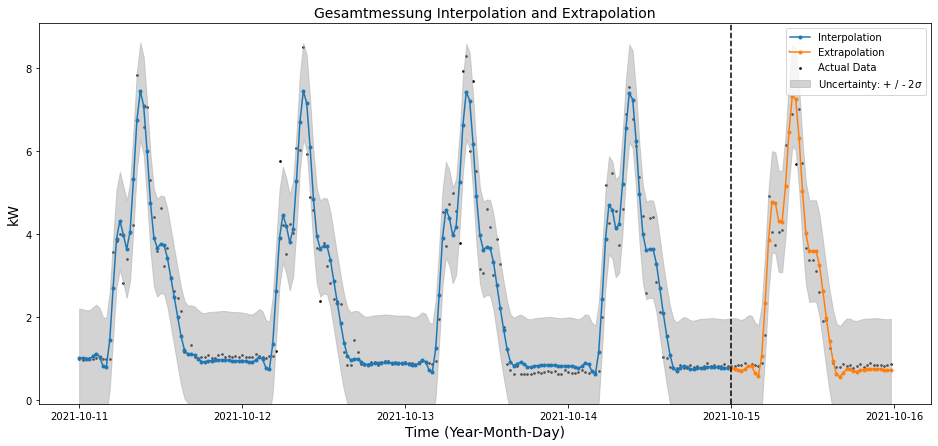

                 time    actual       machine
0 2021-10-12 05:30:00  5.761022  hauptluftung
1 2021-10-13 08:30:00  7.917093  hauptluftung
2 2021-10-13 10:00:00  7.676323  hauptluftung
3 2021-10-14 05:30:00  5.177286  hauptluftung


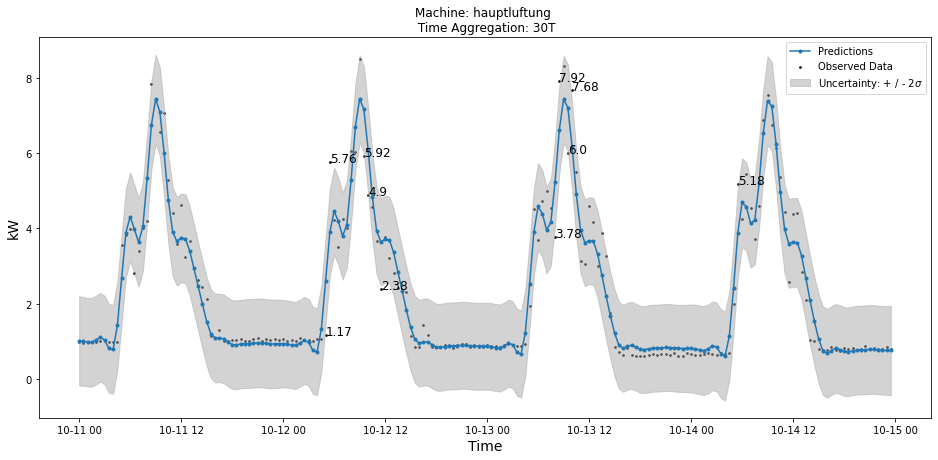

   index                time       machine control_limit  actual_kw  \
0      0 2021-10-15 08:30:00  hauptluftung         upper   8.415399   
1      0 2021-10-15 09:30:00  hauptluftung         lower   5.687064   

   expected_kw     bound  
0     6.450948  7.672620  
1     7.246555  6.024882  


/Users/wastechs/Documents/git-repos/energy-efficiency/validation/gp/create_train_inference.py:520: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ax[0].scatter(orig_time[upper], deviation[upper], color='red')
/Users/wastechs/Documents/git-repos/energy-efficiency/validation/gp/create_train_inference.py:521: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ax[0].scatter(orig_time[lower], deviation[lower], color='red')


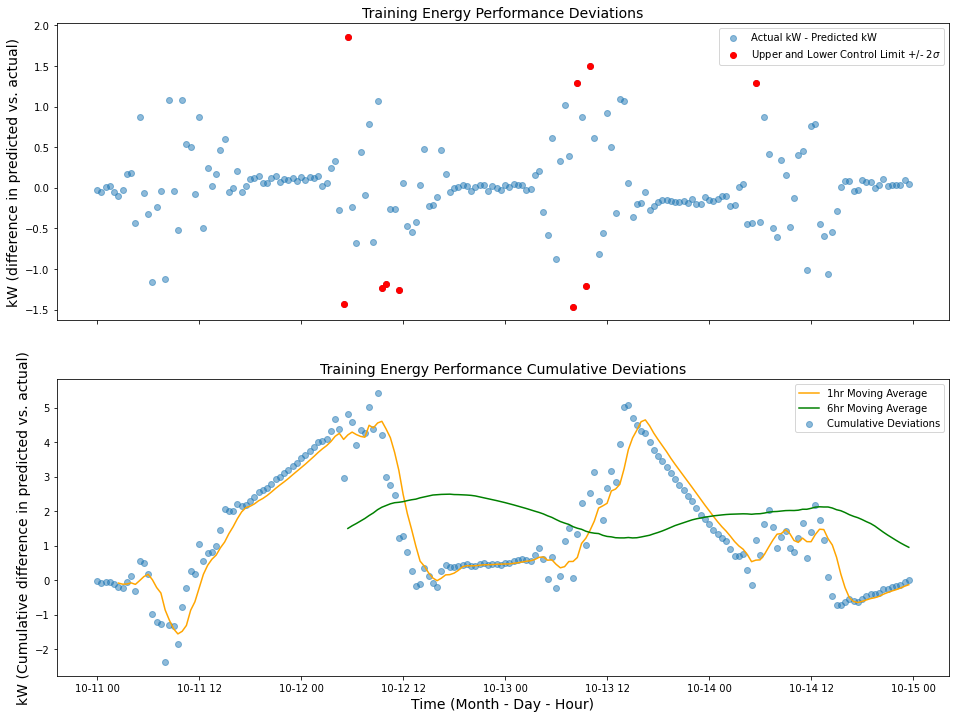

/Users/wastechs/Documents/git-repos/energy-efficiency/validation/gp/create_train_inference.py:564: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ax[0].scatter(test_time[test_vals_upper], test_deviation[test_vals_upper], color='red')
/Users/wastechs/Documents/git-repos/energy-efficiency/validation/gp/create_train_inference.py:565: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ax[0].scatter(test_time[test_vals_lower], test_deviation[test_vals_lower], color='red')


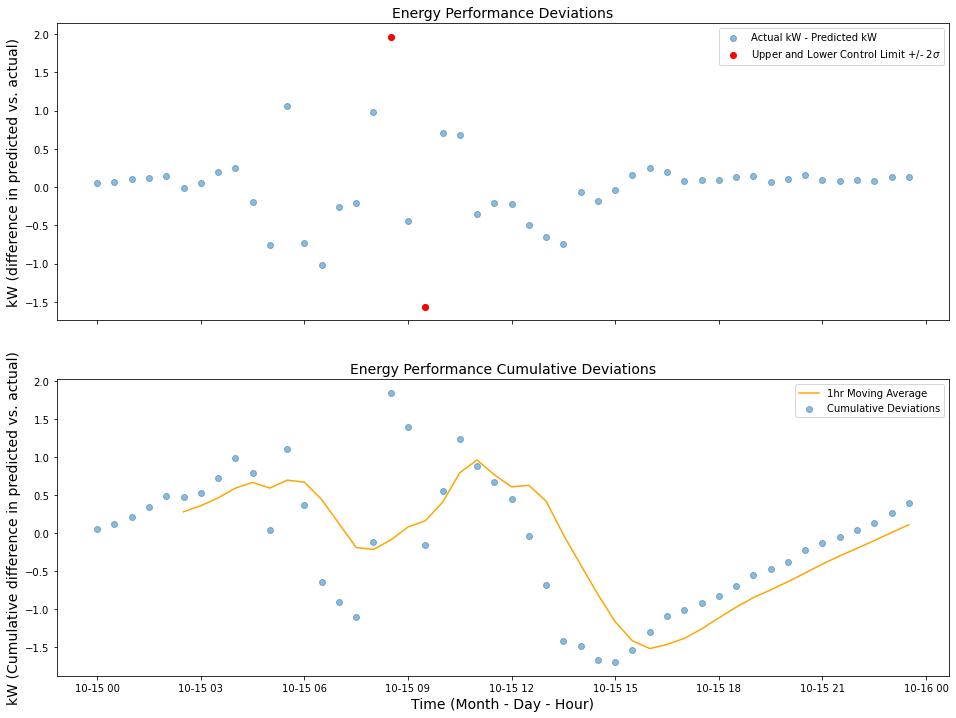

0.9583333333333334 0.1729657955618392


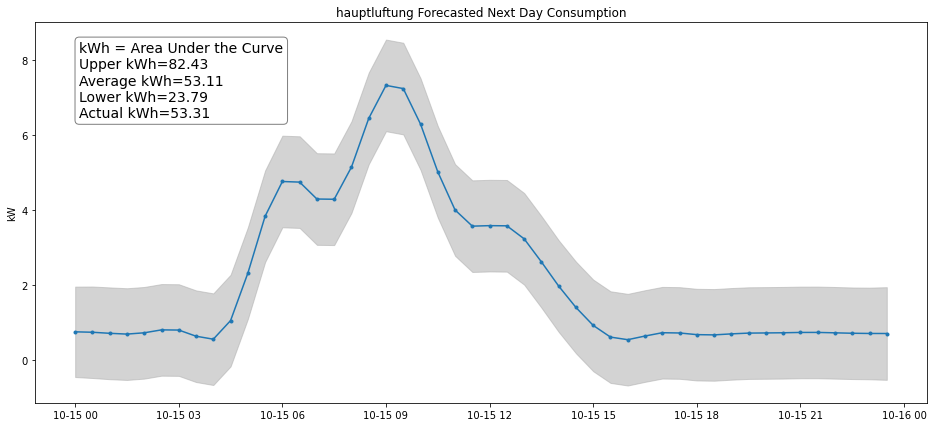

In [4]:
func_preds_mean_inv, func_preds_var_inv, observed_preds, mse, mape = create_train_inference_gp(
    kernel_gen=covar_module6,
    train_x=X_train,
    train_y=y_train,
    test_x=X_test,
    test_y=y_test,
    n_train=n_train,
    training_iter=100,
    lr=0.1,
    time_agg='30T',
    machine='hauptluftung',
    update_score=False
)

In [ ]:
mse, mape

### 10 minutes agg.

In [ ]:
X_train, y_train, X_test, y_test, n_train = data_preprocessing.gp_preprocess(
    machine='hauptluftung_10T', 
    freq=10,
    normalize_time=True
    )

In [ ]:
## Locally Periodic Kernel ##
period_constraint_short = gpytorch.constraints.Interval(0.06, 0.09) ## short term

seasonal_periodic_short = gpytorch.kernels.ScaleKernel(
    gpytorch.kernels.PeriodicKernel(
        period_length_constraint=period_constraint_short
        )
    )

seasonal_rbf_short = gpytorch.kernels.ScaleKernel(
    gpytorch.kernels.RQKernel()
)

locally_short_periodic = seasonal_periodic_short * seasonal_rbf_short

period_constraint_long = gpytorch.constraints.Interval(0.18, 0.21) ## long term

seasonal_periodic_long = gpytorch.kernels.ScaleKernel(
    gpytorch.kernels.PeriodicKernel(
        period_length_constraint=period_constraint_long
        )
    )

seasonal_rbf_long = gpytorch.kernels.ScaleKernel(
    gpytorch.kernels.RQKernel()
)

locally_long_periodic = seasonal_periodic_long * seasonal_rbf_long

## Local Variations ##
local_variation_alpha = gpytorch.priors.GammaPrior(1, 0.5)

local_variation = gpytorch.kernels.ScaleKernel(
    gpytorch.kernels.RQKernel()
    )
    
#local_variation.alpha = local_variation_alpha


#covar_module = locally_short_periodic + locally_long_periodic #+ local_variation ## best
covar_module1 = locally_short_periodic + locally_long_periodic + local_variation 
covar_module2 = locally_short_periodic
covar_module3 = locally_short_periodic + local_variation 
covar_module4 = locally_short_periodic + locally_long_periodic

covar_module5 = locally_long_periodic
covar_module6 = locally_long_periodic + local_variation 

covar_module7 = local_variation

covar_combinations = [
    covar_module1, covar_module2, covar_module3, 
    covar_module4, covar_module5, covar_module6, 
    covar_module7]

In [ ]:
for kernel in covar_combinations:

    X_train, y_train, X_test, y_test, n_train = data_preprocessing.gp_preprocess(
    machine='hauptluftung_10T', 
    freq=10,
    normalize_time=True
    )

    func_preds_mean_inv, func_preds_var_inv, observed_preds, mse, mape = create_train_inference_gp(
        kernel_gen=kernel,
        train_x=X_train,
        train_y=y_train,
        test_x=X_test,
        test_y=y_test,
        n_train=n_train,
        training_iter=100,
        lr=0.1,
        time_agg='10T',
        machine='Hauptluftung',
        update_score=True
    )

In [ ]:
mse, mape

In [ ]:
func_preds_mean_inv, func_preds_var_inv, observed_preds, mse, mape = create_train_inference_gp(
    kernel_gen=covar_module6,
    train_x=X_train,
    train_y=y_train,
    test_x=X_test,
    test_y=y_test,
    n_train=n_train,
    training_iter=100,
    lr=0.1,
    time_agg='10T',
    machine='hauptluftung',
    update_score=False
)

In [ ]:
mse, mape

In [ ]:
np.sqrt(mse)